In [1]:
from langchain_community.document_loaders import DirectoryLoader

In [4]:
loader = DirectoryLoader('./data', glob="**/*.txt")
docs = loader.load()

In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)


In [6]:
docs = text_splitter.split_documents(docs)
texts = [doc.page_content for doc in docs]

In [7]:
import tiktoken

def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [10]:
counts = [num_tokens_from_string(t) for t in texts]


<function matplotlib.pyplot.show(close=None, block=None)>

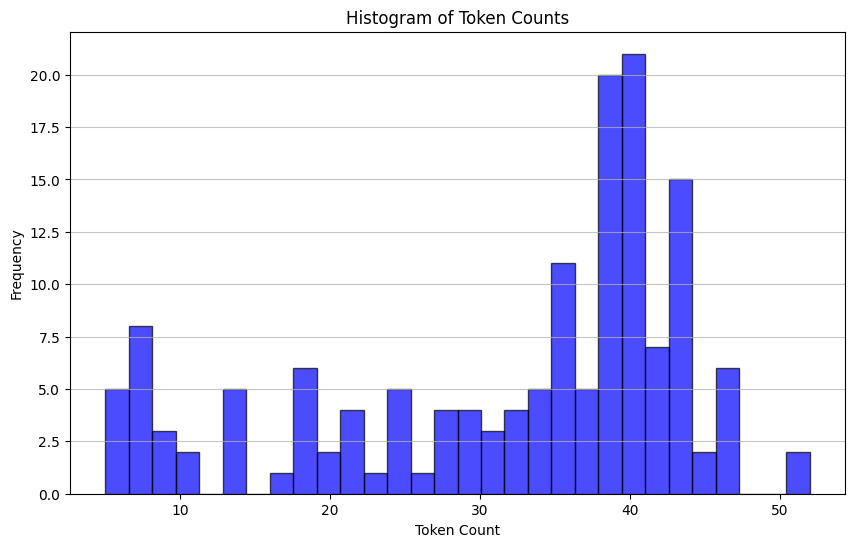

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show

In [12]:
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content)
)

Num tokens in all context: 5250


In [13]:
from langchain_openai import OpenAIEmbeddings, ChatOpenAI

embedding_model = OpenAIEmbeddings()
model = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")

In [14]:
global_embeddings = [embedding_model.embed_query(txt) for txt in texts]
global_embeddings[0]

[0.02129591628909111,
 -0.015194278210401535,
 0.0036689594853669405,
 -0.02948460914194584,
 -0.0033864763099700212,
 0.028367970138788223,
 -0.03214327618479729,
 -0.013957997784018517,
 -0.012083638459444046,
 -0.016736304387450218,
 -0.0026171247009187937,
 0.004210662562400103,
 -0.009996585547924042,
 -0.030601248145103455,
 0.011764598079025745,
 -0.0005612278473563492,
 0.016443850472569466,
 -0.011020171456038952,
 0.018491024151444435,
 -0.003192061325535178,
 -0.027158277109265327,
 0.013512670993804932,
 -0.003339949529618025,
 0.011312625370919704,
 -0.006035172380506992,
 -0.006420678924769163,
 0.007922825403511524,
 -0.022120103240013123,
 -0.0038450961001217365,
 0.015101224184036255,
 -0.015739304944872856,
 -0.015127811580896378,
 -0.013306625187397003,
 -0.03046831488609314,
 -0.002012277953326702,
 -0.030415141955018044,
 0.0034296794328838587,
 -0.0094847921282053,
 0.01693570427596569,
 0.004569582641124725,
 0.0025822296738624573,
 -0.007085345685482025,
 -0.004

In [16]:
import matplotlib.pyplot as plt
from typing import Optional
import numpy as np
import umap

def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)
global_embeddings_reduced[0]

array([4.711635, 5.279045], dtype=float32)

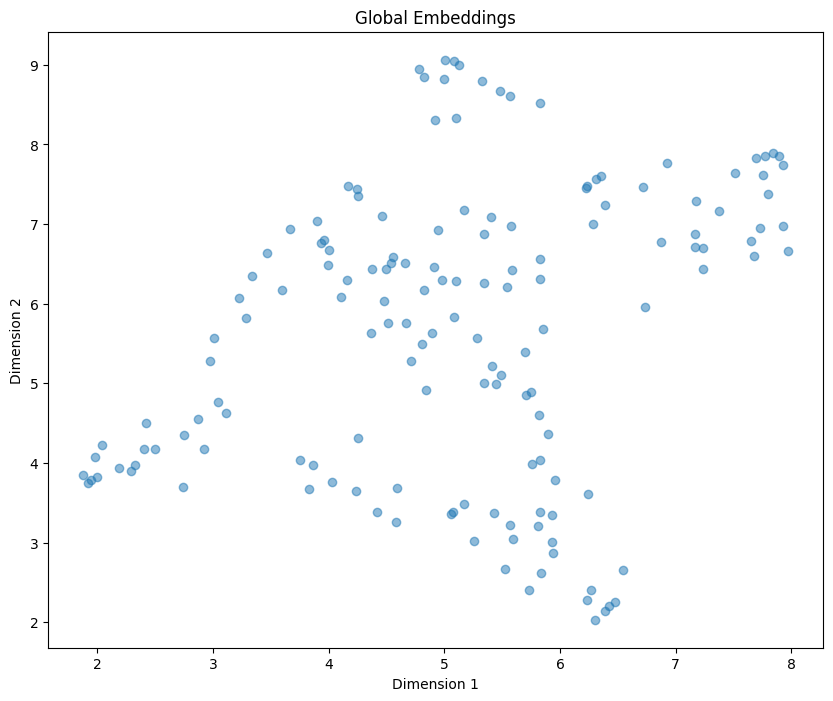

In [17]:
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

def get_optimal_clusters(embeddings: np.ndarray, max_clusters: int = 50, random_state: int = 1234):
    max_clusters = min(max_clusters, len(embeddings))
    bics = [GaussianMixture(n_components=n, random_state=random_state).fit(embeddings).bic(embeddings)
            for n in range(1, max_clusters)]
    return np.argmin(bics) + 1

def gmm_clustering(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state).fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters

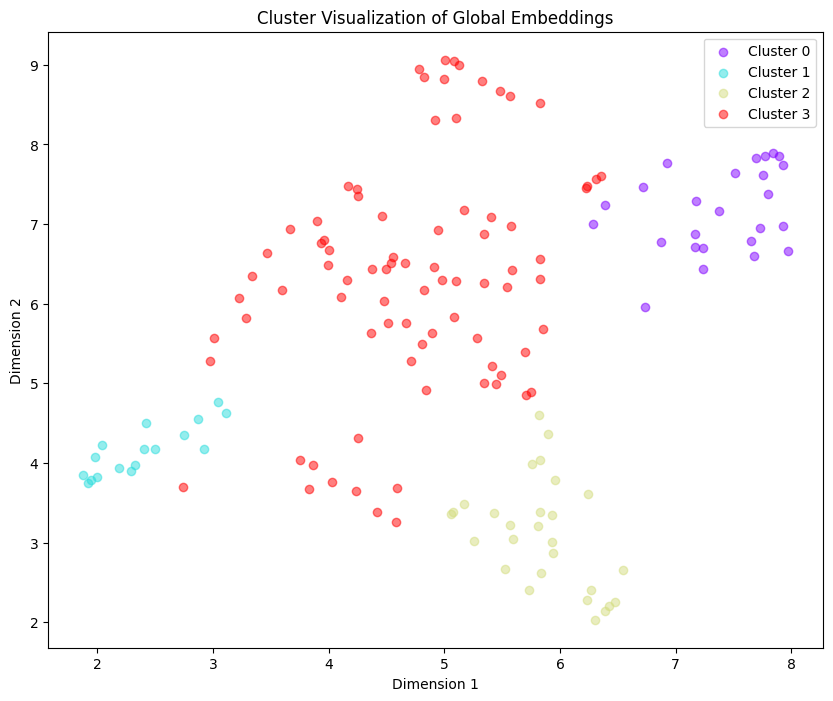

In [19]:
labels, _ = gmm_clustering(global_embeddings_reduced, threshold=0.5)

plot_labels = np.array([label[0] if len(label) > 0 else -1 for label in labels])
plt.figure(figsize=(10, 8))

unique_labels = np.unique(plot_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = plot_labels == label
    plt.scatter(global_embeddings_reduced[mask, 0], global_embeddings_reduced[mask, 1], color=color, label=f'Cluster {label}', alpha=0.5)

plt.title("Cluster Visualization of Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

In [20]:
import pandas as pd

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

df = pd.DataFrame({
    'Text': texts,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': simple_labels
})
print(df.head(3))

                                                Text               Embedding  \
0  Step into our Tuscan-inspired sanctuary, where...    [4.711635, 5.279045]   
1  Tuscany, renowned for its breathtaking country...  [4.6664615, 5.7574167]   
2  Begin your journey with an antipasto platter a...   [2.9217324, 4.173349]   

   Cluster  
0        3  
1        3  
2        1  


In [21]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Text'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

In [22]:
clustered_texts = format_cluster_texts(df)
clustered_texts

{3: 'Step into our Tuscan-inspired sanctuary, where the golden hues of sun-kissed landscapes and the earthy aromas of olive groves and vineyards set the stage for a memorable dining experience. Tuscany, --- Tuscany, renowned for its breathtaking countryside and rich culinary heritage, offers a bounty of flavors and traditions to explore. --- tells a story of generations past, of farmers and artisans who have perfected their craft over centuries. --- Indulge in classics like Ribollita, a hearty vegetable soup enriched with cannellini beans and Tuscan kale. This comforting dish, born out of frugality and resourcefulness, warms both body and soul, --- both body and soul, offering a taste of Tuscan tradition with every spoonful. --- dish celebrates the region\'s abundant seafood while paying homage to the fishermen who have sustained generations with their daily catch. --- As you dine, let the flavors of Tuscany transport you to a simpler time, where meals were savored slowly and each ingr

In [23]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

template = """You are an assistant to create a detailed summary of the text input prodived.
Text:
{text}
"""
prompt = ChatPromptTemplate.from_template(template)
chain = prompt | model | StrOutputParser()

In [24]:
summaries = {}
for cluster, text in clustered_texts.items():
    summary = chain.invoke({"text": text})
    summaries[cluster] = summary

summaries

{3: 'The text describes a culinary journey through various regions of Italy, highlighting the unique flavors and traditions of each area. It starts with a Tuscan-inspired sanctuary, where the golden hues of sun-kissed landscapes and earthy aromas of olive groves set the stage for a memorable dining experience. The text then moves on to Sicily, Venice, Rome, and Naples, each offering a feast for the senses with bold flavors and vibrant colors.\n\nThe chapters also touch on the roots of inspiration, the birth of Bella Vista, the art of hospitality, the culinary visionary, a community of food lovers, the legacy of love, and the power of tradition. The focus is on honoring the time-honored traditions of Italian cuisine while also incorporating creativity and innovation.\n\nThe text emphasizes the importance of using fresh, high-quality ingredients sourced from local farmers and producers to create dishes that are both traditional and innovative. It also highlights the Mediterranean diet, w

In [25]:
embedded_summaries = [embedding_model.embed_query(summary) for summary in summaries.values()]

embedded_summaries_np = np.array(embedded_summaries)

labels, _ = gmm_clustering(embedded_summaries_np, threshold=0.5)

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

In [26]:
clustered_summaries = {}
for i, label in enumerate(simple_labels):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    clustered_summaries[label].append(list(summaries.values())[i])

In [27]:
clustered_summaries

{0: ['The text describes a culinary journey through various regions of Italy, highlighting the unique flavors and traditions of each area. It starts with a Tuscan-inspired sanctuary, where the golden hues of sun-kissed landscapes and earthy aromas of olive groves set the stage for a memorable dining experience. The text then moves on to Sicily, Venice, Rome, and Naples, each offering a feast for the senses with bold flavors and vibrant colors.\n\nThe chapters also touch on the roots of inspiration, the birth of Bella Vista, the art of hospitality, the culinary visionary, a community of food lovers, the legacy of love, and the power of tradition. The focus is on honoring the time-honored traditions of Italian cuisine while also incorporating creativity and innovation.\n\nThe text emphasizes the importance of using fresh, high-quality ingredients sourced from local farmers and producers to create dishes that are both traditional and innovative. It also highlights the Mediterranean diet, 

In [28]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = chain.invoke({"text": combined_text})
    final_summaries[cluster] = summary
final_summaries

{0: "The text provides a detailed summary of a culinary journey through various regions of Italy, focusing on the unique flavors and traditions of each area. It highlights the importance of using fresh, high-quality ingredients sourced from local farmers and producers to create traditional yet innovative dishes. The Mediterranean diet, simplicity, and bold flavors of Italian cuisine are celebrated, with a focus on pasta-making and honoring classic recipes and techniques.\n\nThe text also delves into the founding of Bella Vista, a restaurant inspired by different regions of Italy, and the commitment of its founder, Giovanni, to share the authentic flavors of Italian cuisine with the world. It emphasizes the sensory experience of Italian cuisine and the role of food in bringing people together and creating lasting memories.\n\nGiovanni's culinary journey, starting from his upbringing in Naples and guided by his Nonna Rosa, is detailed, showcasing his passion, creativity, and commitment t

In [29]:
texts_from_df = df['Text'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

In [31]:
from langchain_community.vectorstores import Chroma

# Now, use all_texts to build the vectorstore with Chroma
vectorstore = Chroma.from_texts(texts=combined_texts, embedding=embedding_model)

In [32]:
def adjust_final_number(string: str, max_threshold: int, initial_number: int) -> int:
    final_number = initial_number
    while final_number < max_threshold:
        retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})
        docs = retriever.get_relevant_documents(string)
        text = "".join([doc.page_content for doc in docs])
        if num_tokens_from_string(text) < max_threshold:
            final_number += 1
        else:
            break
    return final_number

final_number = adjust_final_number("Who is the owner of the restaurant", 10000, 4)

c:\Users\ernan\anaconda3\envs\graph\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [33]:
final_number

157

In [34]:
retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})

In [35]:
from langchain_core.runnables import RunnablePassthrough

template = """
Answer the question based only on the following context:
{context}

Answer the following question:
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [36]:
rag_chain.invoke("Who is the owner of the restaurant")

'Giovanni Di Napoli is the owner of the restaurant, Bella Vista.'